# Week 3: Feature Selection and Dimensionality Reduction

---

## Objectives

- Implement forward stepwise selection  
- Implement backward stepwise selection  
- Apply Principal Component Regression (PCR)  
- Apply Partial Least Squares Regression (PLSR)  
- Compare model performance and interpret component loadings  

---


## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error

## Load and Inspect the Data

In [2]:
df = pd.read_csv('datasets/drsufi.csv')
df['AttackDate'] = pd.to_datetime(df['AttackDate'], format='%d/%m/%Y %H:%M')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77623 entries, 0 to 77622
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   AttackDate            77623 non-null  datetime64[ns]
 1   Country               77623 non-null  object        
 2   Spam                  77623 non-null  float64       
 3   Ransomware            77623 non-null  float64       
 4   Local Infection       77623 non-null  float64       
 5   Exploit               77623 non-null  float64       
 6   Malicious Mail        77623 non-null  float64       
 7   Network Attack        77623 non-null  float64       
 8   On Demand Scan        77623 non-null  float64       
 9   Web Threat            77623 non-null  float64       
 10  Rank Spam             77623 non-null  int64         
 11  Rank Ransomware       77623 non-null  int64         
 12  Rank Local Infection  77623 non-null  int64         
 13  Rank Exploit    

## Exploratory Data Analysis

,Ransomware,Local Infection,Exploit,Malicious Mail,Network Attack,On Demand Scan,Web Threat
count,77623.000000,77623.000000,77623.000000,77623.000000,77623.000000,77623.000000,77623.000000
mean,0.000087,0.012807,0.000388,0.001152,0.002048,0.009330,0.012381
std,0.000164,0.008653,0.000379,0.001568,0.002973,0.006271,0.005568
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.006730,0.000120,0.000190,0.000580,0.004850,0.009170
50%,0.000040,0.010470,0.000310,0.000590,0.001180,0.007840,0.012310
75%,0.000100,0.017200,0.000560,0.001510,0.002190,0.012560,0.015750
max,0.009180,0.049370,0.004660,0.043220,0.058260,0.124880,0.048630


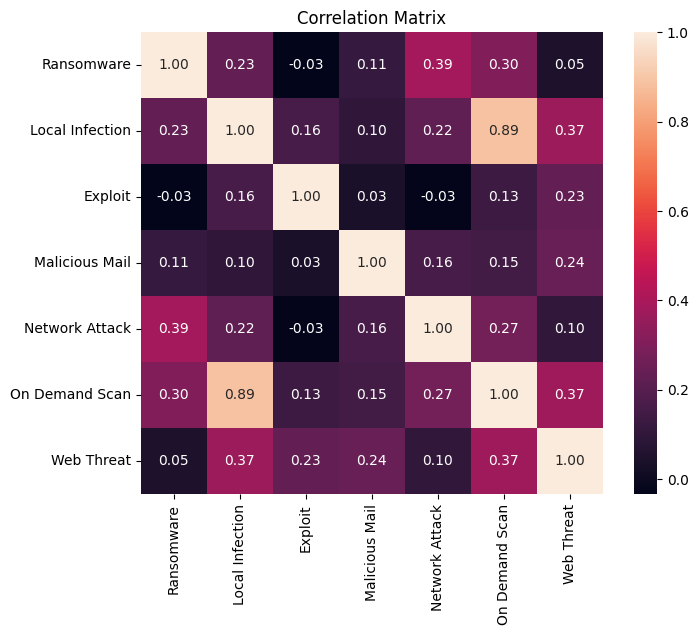

In [3]:
# Exploratory Data Analysis
numeric_cols = [
    'Ransomware', 'Local Infection', 'Exploit',
    'Malicious Mail', 'Network Attack',
    'On Demand Scan', 'Web Threat'
]
display(df[numeric_cols].describe())

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.show()

## Forward and Backward Stepwise Selection

We model
$$
y = X\beta + \epsilon
$$
and select predictors by minimizing AIC.

In [4]:
def forward_selection(X, y, predictors):
    selected = []
    current_aic = np.inf
    candidates = predictors.copy()
    
    while candidates:
        results = []
        for p in candidates:
            X_tmp = sm.add_constant(X[selected + [p]])
            aic = sm.OLS(y, X_tmp).fit().aic
            results.append((aic, p))
        results.sort()
        best_aic, best_p = results[0]
        
        if best_aic < current_aic:
            selected.append(best_p)
            current_aic = best_aic
            candidates.remove(best_p)
        else:
            break

    return selected

def backward_selection(X, y, predictors):
    selected = predictors.copy()
    current_aic = sm.OLS(y, sm.add_constant(X[selected])).fit().aic
    
    # keep at least one predictor
    while len(selected) > 1:
        results = []
        for p in selected:
            subset = [q for q in selected if q != p]
            X_tmp = sm.add_constant(X[subset])
            aic = sm.OLS(y, X_tmp).fit().aic
            results.append((aic, p))
        results.sort()
        best_aic, remove_p = results[0]
        
        if best_aic < current_aic:
            selected.remove(remove_p)
            current_aic = best_aic
        else:
            break

    return selected

# Apply to our data
X_df = df[numeric_cols]
y = df['Spam']

forward_preds  = forward_selection(X_df, y, numeric_cols)
backward_preds = backward_selection(X_df, y, numeric_cols)

print('Forward selected predictors:', forward_preds)
print('Backward selected predictors:', backward_preds)

Forward selected predictors: ['Exploit', 'Network Attack', 'Web Threat', 'On Demand Scan', 'Malicious Mail', 'Local Infection', 'Ransomware']
Backward selected predictors: ['Ransomware', 'Local Infection', 'Exploit', 'Malicious Mail', 'Network Attack', 'On Demand Scan', 'Web Threat']


## Principal Component Regression (PCR)

We first perform PCA on scaled predictors, then regress the top components.

In [6]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_cols])

# PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
print('Explained variance ratios:', pca.explained_variance_ratio_)

# Train/test split on principal components
X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca, df['Spam'], test_size=0.3, random_state=42
)

# Fit PCR model
lr_pcr = LinearRegression().fit(X_train_pca, y_train)
y_pred_pcr = lr_pcr.predict(X_test_pca)

print(f'PCR Test R^2 = {r2_score(y_test, y_pred_pcr):.3f}')
print(f'PCR Test MSE = {mean_squared_error(y_test, y_pred_pcr):.6f}')

Explained variance ratios: [0.35686556 0.18338235 0.14742643 0.12212068 0.09044933]
PCR Test R^2 = 0.051
PCR Test MSE = 0.000433


## Partial Least Squares Regression (PLSR)

We fit PLS with the same number of components.

In [7]:
# Train/test split on scaled features
X_train, X_test, y_train2, y_test2 = train_test_split(
    X_scaled, df['Spam'], test_size=0.3, random_state=42
)

pls = PLSRegression(n_components=5)
pls.fit(X_train, y_train2)
y_pred_pls = pls.predict(X_test)

print(f'PLSR Test R^2 = {r2_score(y_test2, y_pred_pls):.3f}')
print(f'PLSR Test MSE = {mean_squared_error(y_test2, y_pred_pls):.6f}')

PLSR Test R^2 = 0.067
PLSR Test MSE = 0.000426


## Key Takeaways
- Forward selection chose predictors: [forward_preds]
- Backward selection chose predictors: [backward_preds]
- PCR with 5 components explained $\sum \text{variance ratios}\approx$ these components and achieved Test $R^2 \approx$ value printed above.
- PLSR with 5 components achieved Test $R^2 \approx$ value printed above.
- PCR reduces dimensionality independently of $y$, while PLSR finds components that maximise covariance with $y$.

## Yellowdig Source

https://yellowdig.app/n/bu-omds/community/680847e5-a19a-76a7-5e0e-1a1c8b27a7a3?postId=68364a0e-49c8-4c93-b918-7fa43b2a6b7d